In [262]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [263]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [264]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [265]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

# Hyper params

In [266]:
train_delta_t = 0
max_depth = 4
eval_metric = 'rmse'
n_estimators = 4000
scaler_name = 'StandardScaler'
scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()
random_state = 42
interpolation_method = 'linear' # 'from_derivatives'
submission_path = '8nov_sub/'
test_set_param = 'rd_set' # 'basic'
eta = 1e-2

In [267]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

In [268]:
# def add_linear_value_to_output(df):
#     new_df = df.copy()

#     for i in range(len(df) - 1):
#         row = df.iloc[i]
#         next_row = df.iloc[i + 1]
#         if next_row['time'] == row['time'] + pd.Timedelta(hours=1):
#             quarter_hour = 0.75 * row['pv_measurement'] + 0.25 * next_row['pv_measurement']
#             half_hour = 0.5 * row['pv_measurement'] + 0.5 * next_row['pv_measurement']
#             three_quarters_hour = 0.25 * row['pv_measurement'] + 0.75 * next_row['pv_measurement']

#             new_df = pd.concat([new_df, pd.DataFrame({'time': [row['time'] + pd.Timedelta(minutes=15)], 'pv_measurement': [quarter_hour]})], ignore_index=True)
#             new_df = pd.concat([new_df, pd.DataFrame({'time': [row['time'] + pd.Timedelta(minutes=30)], 'pv_measurement': [half_hour]})], ignore_index=True)
#             new_df = pd.concat([new_df, pd.DataFrame({'time': [row['time'] + pd.Timedelta(minutes=45)], 'pv_measurement': [three_quarters_hour]})], ignore_index=True)

#     new_df = new_df.sort_values(by='time')
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df

In [269]:
def interpolate_output_values(df):
    freq = '15T'
    df = df.set_index('time').resample(freq).asfreq()
    df['pv_measurement'] = df['pv_measurement'].interpolate(method=interpolation_method)
    df = df.reset_index()
    return df

In [270]:
train_a = interpolate_output_values(train_a)
train_b = interpolate_output_values(train_b)
train_c = interpolate_output_values(train_c)

# B and C clean up

In [271]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [272]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [273]:
delta = { 'hours': 12 * 4 }
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [274]:
# delta_title = str(train_delta_t)
# delta_h = pd.Timedelta(minutes=train_delta_t)
# train_a['date_forecast'] = train_a['time'] - delta_h
# train_b['date_forecast'] = train_b['time'] - delta_h
# train_c['date_forecast'] = train_c['time'] - delta_h

# Réorganisation des df :

In [275]:
len(X_train_observed_a), len(X_train_estimated_a)

(118669, 17576)

In [276]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a, X_train_estimated_a], ignore_index=True)
X_total_b = pd.concat([X_train_observed_b, X_train_estimated_b], ignore_index=True)
X_total_c = pd.concat([X_train_observed_c, X_train_estimated_c], ignore_index=True)

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

In [277]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
# train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [278]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

In [279]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [280]:
def gestion_nan(df):
  df_copy = df.copy()
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  df_copy[f'ceiling_height_agl:m'] = df_copy[f'ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy[f'cloud_base_agl:m'] = df_copy[f'cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [281]:
def gestion_constant_columns(df, location):
    columns_to_drop = X_test_estimated_a.std()[X_test_estimated_a.std() == 0].keys() if location=='A' else X_test_estimated_b.std()[X_test_estimated_b.std() == 0].keys() if location=='B' else  X_test_estimated_c.std()[X_test_estimated_c.std() == 0].keys()
    return df.drop(columns=columns_to_drop)

In [282]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [283]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [284]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [285]:

X_total_a_y_nan = gestion_constant_columns(X_total_a_y_nan, 'A')
X_total_b_y_nan = gestion_constant_columns(X_total_b_y_nan, 'B')
X_total_c_y_nan = gestion_constant_columns(X_total_c_y_nan, 'C')

In [286]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [287]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [288]:
start_2019 = pd.to_datetime("2019-04-21")
end_2019 = pd.to_datetime("2019-07-22")

start_2020 = pd.to_datetime("2020-04-21")
end_2020 = pd.to_datetime("2020-07-22")

start_2021 = pd.to_datetime("2021-04-21")
end_2021 = pd.to_datetime("2021-07-22")

start_2022 = pd.to_datetime("2022-04-21")
end_2022 = pd.to_datetime("2022-07-22")

In [289]:
def create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast'):
    # mask_2019 = ((df[time_column] >= start_2019) & (df[time_column] < end_2019))
    mask_2020 = ((df[time_column] >= start_2020) & (df[time_column] < end_2020))
    mask_2021 = ((df[time_column] >= start_2021) & (df[time_column] < end_2021))
    mask_2022 = ((df[time_column] >= start_2022) & (df[time_column] < end_2022))
    mask_estimated = (df[time_column] >= start_estimated)
    # return mask_2019, mask_2020, mask_2021, mask_2022,mask_estimated
    return mask_2020, mask_2021, mask_2022,mask_estimated

In [290]:
def split_training_testing_set_on_test_set_dates():
    quantile = .25
    pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= X_train_estimated_a['date_forecast'].quantile(quantile)].copy()
    pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > X_train_estimated_a['date_forecast'].quantile(quantile)].copy()

    pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= X_train_estimated_b['date_forecast'].quantile(quantile)].copy()
    pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > X_train_estimated_b['date_forecast'].quantile(quantile)].copy()

    pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= X_train_estimated_c['date_forecast'].quantile(quantile)].copy()
    pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > X_train_estimated_c['date_forecast'].quantile(quantile)].copy() 
    return pv_train_a, pv_test_a, pv_train_b, pv_test_b, pv_train_c, pv_test_c

In [291]:
# def split_training_testing_set(df, start_estimated, random_state=42, test_size = .15, time_column = 'date_forecast'):
#     df_to_split = df.copy()
#     mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

#     df_summers = df_to_split[ mask_2021 | mask_2022]
#     df_estimated = df_to_split[mask_estimated]
#     print(len(df_estimated))
#     df_not_summer = df_to_split[~(mask_2021 | mask_2022 | mask_estimated)]

#     # test_size_summer = test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) / (len(df_summers) + len(df_estimated))
#     # test_size_estimated = test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) / (len(df_summers) + len(df_estimated))

#     test_size_estimated = 0.8
#     test_size_summer = ( test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) - test_size_estimated * len(df_estimated) ) / len(df_summers)
#     # test_size_summer = ( test_size * (len(df_summers) + len(df_not_summer) + len(df_estimated)) - test_size_estimated * len(df_estimated) ) / len(df_summers)
#     # test_size_estimated = 1 - test_size_summer
#     # train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

#     unique_dates_summer = df_summers[time_column].dt.date.unique()
#     unique_dates_estimated = df_summers[time_column].dt.date.unique()

#     train_dates_summer, test_dates_summer = train_test_split(unique_dates_summer, test_size=test_size_summer, random_state=random_state)
#     train_dates_estimated, test_dates_estimated = train_test_split(unique_dates_estimated, test_size=test_size_estimated, random_state=random_state)

#     train_data_summer = df_summers[df_summers[time_column].dt.date.isin(train_dates_summer)]
#     train_data_estimated = df_estimated[df_estimated[time_column].dt.date.isin(train_dates_estimated)]

#     pv_test_summer_not_ordered = df_summers[df_summers[time_column].dt.date.isin(test_dates_summer)]
#     pv_test_estimated_not_ordered = df_estimated[df_estimated[time_column].dt.date.isin(test_dates_estimated)]

#     pv_test_not_ordered = pd.concat([pv_test_summer_not_ordered, pv_test_estimated_not_ordered])
#     pv_train_not_ordered = pd.concat([train_data_summer, train_data_estimated, df_not_summer])

#     pv_train = pv_train_not_ordered.sort_values(by=time_column)
#     pv_test = pv_test_not_ordered.sort_values(by=time_column)
#     return pv_train, pv_test

In [292]:
def split_training_testing_set(df, start_estimated, random_state=42, test_size = .1, time_column = 'date_forecast'):
    df_to_split = df.copy()
    # mask_2019, mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)
    mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)
    # mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)
    df_summers = df_to_split[ mask_2020 | mask_2021 | mask_2022 | mask_estimated]
    df_not_summer = df_to_split[~(mask_2020 | mask_2021 | mask_2022 | mask_estimated)]
    test_size = test_size * (len(df_summers) + len(df_not_summer)) / len(df_summers)
    train_data_summer, pv_test_not_ordered = train_test_split(df_summers, test_size=test_size, random_state=random_state)

    pv_train_not_ordered = pd.concat([train_data_summer, df_not_summer])
    pv_train = pv_train_not_ordered.sort_values(by='date_forecast')
    pv_test = pv_test_not_ordered.sort_values(by='date_forecast')
    return pv_train, pv_test

In [293]:
# create_mask_for_split_training_and_testing(df, start_estimated, time_column = 'date_forecast')
df_to_split = X_total_b_y_nan
start_estimated = X_train_estimated_b["date_forecast"].mean()
mask_2020, mask_2021, mask_2022, mask_estimated = create_mask_for_split_training_and_testing(df_to_split, start_estimated)

In [294]:
pv_train_a, pv_test_a = split_training_testing_set(X_total_a_y_nan, X_train_estimated_a["date_forecast"].mean(), random_state=random_state)
pv_train_b, pv_test_b = split_training_testing_set(X_total_b_y_nan, X_train_estimated_b["date_forecast"].mean(), random_state=random_state)
pv_train_c, pv_test_c = split_training_testing_set(X_total_c_y_nan, X_train_estimated_c["date_forecast"].mean(), random_state=random_state)

In [295]:
if test_set_param=='basic': pv_train_a, pv_test_a, pv_train_b, pv_test_b, pv_train_c, pv_test_c = split_training_testing_set_on_test_set_dates()

In [296]:

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100, '%')
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100, '%')
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100, '%')

train_a : (122556, 41)
test_a : (13618, 41)
Rapport test/total : 10.0 %
train_b : (99770, 36)
test_b : (11086, 36)
Rapport test/total : 10.0 %
train_c : (83077, 43)
test_c : (9231, 43)
Rapport test/total : 10.0 %


## Changement type de la date_forecast

In [297]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [298]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) if "date_calc" in df.columns else df.drop(["date_forecast"],axis=1)
    
    df[f'sun_azimuth:d'] = df[f'sun_azimuth:d'].apply(lambda x : np.cos(x/180*np.pi + np.pi))
    
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [299]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Normalisation

In [300]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None,fit=True):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : 
      if fit:
        normalized_data = scaler.fit_transform(df)
      else: 
        normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [301]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True, scaler=scaler_a)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True, scaler=scaler_b)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True, scaler=scaler_c)

In [302]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a, fit=False)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b, fit=False)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c, fit=False)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [303]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [304]:
hyper_params_a = {'n_estimators': 4000, 'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 0.5, 'eta': 0.01, 'colsample_bytree': 1.0}
# BEST ESTIMATION -- BELLOW
hyper_params_a = {'subsample': 0.6, 'refresh_leaf': 1, 'n_estimators': 4000, 'min_child_weight': 15, 'max_depth': 4, 'gamma': 0.5, 'eta': 0.005, 'colsample_bytree': 0.8}
hyper_params_b = {'n_estimators': 4000, 'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0.5, 'eta': 0.01, 'colsample_bytree': 0.6}
hyper_params_c = {'n_estimators': 4000, 'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0.5, 'eta': 0.05, 'colsample_bytree': 1.0}
# BEST ESTIMATION -- ABOVE
hyper_params_b = {
    'n_estimators': 4000, 
    'subsample': 0.6,
    'min_child_weight': 5,
    'max_depth': 5,
    'gamma': 0.5,
    'colsample_bytree': 0.6,
    'refresh_leaf': 1,
    'eta': 0.01
    }

hyper_params_c = {
    'n_estimators': 4000, 
    'subsample': 0.6,
    'min_child_weight': 5,
    'max_depth': 5,
    'gamma': 0.5,
    'colsample_bytree': 1.0,
    'refresh_leaf': 1,
    'eta': 0.05
    }

In [305]:
reg_a = xgb.XGBRegressor(
    # n_estimators = n_estimators,
    # max_depth = max_depth,
    eval_metric = eval_metric,
    # eta=eta,
    **hyper_params_a
    )


reg_b = xgb.XGBRegressor(
    # n_estimators = n_estimators,
    # max_depth = max_depth,
    eval_metric = eval_metric,
    # eta=eta,
    **hyper_params_b
    )

reg_c = xgb.XGBRegressor(
    # n_estimators = n_estimators,
    # max_depth = max_depth,
    eval_metric = eval_metric,
    # eta=eta,
    **hyper_params_c
    )

In [306]:
# gen_params = {
#         'n_estimators': [2000, 3000, 3500],
#         # 'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 5],
#         'subsample': [0.6, 1.0],
#         # 'colsample_bytree': [0.6, 1.0],
#         'max_depth': [4, 5],
#         'eta': [ 0.005, 0.01, 0.05],
#         # 'refresh_leaf': [ 1 ],
#         'n_estimators': [ 3000, 4000 ]
#         # 'num_boost_round': 128,
#         }

# params_a = {
#         'min_child_weight': [ 10, 12, 15 ],
#         # 'gamma': [0.5, 1, 2, 5],
#         # 'subsample': [0.6, 1.0],
#         'colsample_bytree': [0.8, 1.0],
#         # 'max_depth': [3, 5],
#         # 'eta': [ 0.005, 0.01, 0.05],
#         'refresh_leaf': [ .7, 1 ],
#         **gen_params
#         # 'num_boost_round': 128,
#         }

# params_b = {
#         'min_child_weight': [3, 5, 7],
#         # 'gamma': [0.5, 1, 2, 5],
#         # 'subsample': [0.6, 1.0],
#         'colsample_bytree': [.7, 0.6, .5],
#         # 'max_depth': [3, 5],
#         # 'eta': [ 0.005, 0.01, 0.05],
#         'refresh_leaf': [ 1 ],
#         **gen_params
#         # 'num_boost_round': 128,
#         }

# params_c = {
#         'min_child_weight': [3, 5, 7],
#         # 'gamma': [0.5, 1, 2, 5],
#         # 'subsample': [0.6, 1.0],
#         'colsample_bytree': [ 0.6 ],
#         # 'max_depth': [3, 5],
#         # 'eta': [ 0.005, 0.01, 0.05],
#         'refresh_leaf': [ 1 ],
#         **gen_params
#         # 'num_boost_round': 128,
#         }

base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric='rmse',
             feature_types=None, gamma=5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None,

In [307]:

# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#             #   'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [0, 4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

In [308]:
# from functools import reduce
# lens_a = [len(v) for v in params_a.values()]
# lens_b = [len(v) for v in params_b.values()]
# lens_c = [len(v) for v in params_c.values()]
# def product(a):
#     return reduce(lambda x,y: x*y, a)

In [309]:
# product(lens_a), product(lens_b), product(lens_c)

In [310]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
# from sklearn.metrics import mean_squared_error

# param_comb_a = product(lens_a)
# param_comb_b = product(lens_b)
# param_comb_c = product(lens_c)
# n_jobs = 10


# random_search_a = RandomizedSearchCV(reg_a, param_distributions=params_a, n_iter=param_comb_a, scoring='neg_mean_squared_error', n_jobs=n_jobs, cv=2, verbose=3, random_state=1001 )
# random_search_b = RandomizedSearchCV(reg_b, param_distributions=params_b, n_iter=param_comb_b, scoring='neg_mean_squared_error', n_jobs=n_jobs, cv=2, verbose=3, random_state=1001 )
# random_search_c = RandomizedSearchCV(reg_c, param_distributions=params_c, n_iter=param_comb_c, scoring='neg_mean_squared_error', n_jobs=n_jobs, cv=2, verbose=3, random_state=1001 )


In [311]:
# xgb_grid = GridSearchCV(reg_a,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

# random_search_a.fit(
#     X_train_a_norm, y_train_a,
#     eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
#     early_stopping_rounds=50,
#     verbose=True,
#     )

In [312]:
# reg_a.fit(X_train_a_norm, y_train_a,
#           eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
#           early_stopping_rounds=50,
#           verbose=True,
#           )
# reg_b.fit(X_train_b_norm, y_train_b,
#           eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
#           early_stopping_rounds=50,
#           verbose=True,
#           )
# reg_c.fit(X_train_c_norm, y_train_c,
#           eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
#           early_stopping_rounds=50,
#           verbose=True,
#           )

In [313]:
# random_search_a.fit(
#     X_train_a_norm, y_train_a,
#     eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
#     early_stopping_rounds=50,
#     verbose=True,
#     )

In [314]:
# print('\n All results:')
# # print(random_search_a.cv_results_)
# print('\n Best estimator:')
# print(random_search_a.best_estimator_)
# # print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search_a.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search_a.best_params_)
# # results_a = pd.DataFrame(random_search_a.cv_results_)

{'subsample': 0.6, 'refresh_leaf': 1, 'n_estimators': 4000, 'min_child_weight': 15, 'max_depth': 4, 'gamma': 0.5, 'eta': 0.005, 'colsample_bytree': 0.8}

In [315]:
# random_search_b.fit(
#     X_train_b_norm, y_train_b,
#     eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
#     early_stopping_rounds=50,
#     verbose=True,
#     )

In [316]:
# print('\n All results:')
# print(random_search_b.cv_results_)
# print('\n Best estimator:')
# print(random_search_b.best_estimator_)
# # print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search_b.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search_b.best_params_)
# # results_b = pd.DataFrame(random_search_b.cv_results_)

In [317]:
# random_search_c.fit(
#     X_train_c_norm, y_train_c,
#     eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
#     early_stopping_rounds=50,
#     verbose=True,
#     )

A: 
{'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.8}

{'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1.5, 'eta': 0.1, 'colsample_bytree': 0.8}

B: 
{'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}

{'subsample': 0.8, 'refresh_leaf': 1, 'min_child_weight': 10, 'max_depth': 10, 'gamma': 1, 'eta': 0.01, 'colsample_bytree': 1.0}

In [318]:
# print('\n All results:')
# print(random_search_c.cv_results_)
# print('\n Best estimator:')
# print(random_search_c.best_estimator_)
# # print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search_c.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search_c.best_params_)
# # results_c = pd.DataFrame(random_search_c.cv_results_)

C: 
{'max_depth': 3, 'gamma': 1, 'colsample_bytree': 0.6}

{'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 1.5, 'eta': 0.005, 'colsample_bytree': 0.6}

Best: 

A: {'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 0.5, 'eta': 0.01, 'colsample_bytree': 1.0}

B: {'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 5, 'max_depth': 
5, 'gamma': 0.5, 'eta': 0.01, 'colsample_bytree': 0.6}

C: {'subsample': 0.6, 'refresh_leaf': 1, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0.5, 'eta': 0.05, 'colsample_bytree': 1.0}

In [319]:
# reg_a = random_search_a.best_estimator_
# reg_b = random_search_b.best_estimator_
# reg_c = random_search_c.best_estimator_

In [320]:
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True,
          )
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True,
          )
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True,
          )

[0]	validation_0-rmse:1097.90639	validation_1-rmse:1529.95010
[1]	validation_0-rmse:1093.60624	validation_1-rmse:1523.90305
[2]	validation_0-rmse:1089.17649	validation_1-rmse:1517.68950
[3]	validation_0-rmse:1084.77054	validation_1-rmse:1511.48559
[4]	validation_0-rmse:1080.39521	validation_1-rmse:1505.34958
[5]	validation_0-rmse:1076.05197	validation_1-rmse:1499.22518
[6]	validation_0-rmse:1071.74020	validation_1-rmse:1493.13130
[7]	validation_0-rmse:1067.43929	validation_1-rmse:1487.12444
[8]	validation_0-rmse:1063.21480	validation_1-rmse:1481.28626
[9]	validation_0-rmse:1058.95315	validation_1-rmse:1475.30438
[10]	validation_0-rmse:1054.73650	validation_1-rmse:1469.37524
[11]	validation_0-rmse:1050.53528	validation_1-rmse:1463.47606
[12]	validation_0-rmse:1046.36477	validation_1-rmse:1457.58493
[13]	validation_0-rmse:1042.21345	validation_1-rmse:1451.75168
[14]	validation_0-rmse:1038.08043	validation_1-rmse:1445.96052
[15]	validation_0-rmse:1034.11737	validation_1-rmse:1440.36826
[1

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-rmse:994.40612	validation_1-rmse:1384.30520
[26]	validation_0-rmse:990.54721	validation_1-rmse:1378.87872
[27]	validation_0-rmse:986.71269	validation_1-rmse:1373.43847
[28]	validation_0-rmse:982.96070	validation_1-rmse:1368.18781
[29]	validation_0-rmse:979.15716	validation_1-rmse:1362.80278
[30]	validation_0-rmse:975.38248	validation_1-rmse:1357.44694
[31]	validation_0-rmse:971.63854	validation_1-rmse:1352.14273
[32]	validation_0-rmse:968.03009	validation_1-rmse:1347.20916
[33]	validation_0-rmse:964.31959	validation_1-rmse:1341.99463
[34]	validation_0-rmse:960.65375	validation_1-rmse:1336.83433
[35]	validation_0-rmse:956.98649	validation_1-rmse:1331.58861
[36]	validation_0-rmse:953.35953	validation_1-rmse:1326.49410
[37]	validation_0-rmse:949.74903	validation_1-rmse:1321.40976
[38]	validation_0-rmse:946.22452	validation_1-rmse:1316.44850
[39]	validation_0-rmse:942.67978	validation_1-rmse:1311.29073
[40]	validation_0-rmse:939.15475	validation_1-rmse:1306.25066
[41]	val

[58]	validation_0-rmse:879.03298	validation_1-rmse:1221.08521
[59]	validation_0-rmse:875.87463	validation_1-rmse:1216.62845
[60]	validation_0-rmse:872.77420	validation_1-rmse:1212.29383
[61]	validation_0-rmse:869.66197	validation_1-rmse:1207.88057
[62]	validation_0-rmse:866.58902	validation_1-rmse:1203.58779
[63]	validation_0-rmse:863.51655	validation_1-rmse:1199.19474
[64]	validation_0-rmse:860.42621	validation_1-rmse:1194.81682
[65]	validation_0-rmse:857.36458	validation_1-rmse:1190.49517
[66]	validation_0-rmse:854.35305	validation_1-rmse:1186.15345
[67]	validation_0-rmse:851.34964	validation_1-rmse:1181.90237
[68]	validation_0-rmse:848.35869	validation_1-rmse:1177.69063
[69]	validation_0-rmse:845.39195	validation_1-rmse:1173.42663
[70]	validation_0-rmse:842.43082	validation_1-rmse:1169.21575
[71]	validation_0-rmse:839.61203	validation_1-rmse:1165.26810
[72]	validation_0-rmse:836.68472	validation_1-rmse:1161.05481
[73]	validation_0-rmse:833.79676	validation_1-rmse:1156.95106
[74]	val

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:157.24347	validation_1-rmse:233.87091
[25]	validation_0-rmse:155.96591	validation_1-rmse:231.95187
[26]	validation_0-rmse:154.70100	validation_1-rmse:230.06107
[27]	validation_0-rmse:153.45776	validation_1-rmse:228.21389
[28]	validation_0-rmse:152.22495	validation_1-rmse:226.35211
[29]	validation_0-rmse:151.01077	validation_1-rmse:224.52534
[30]	validation_0-rmse:149.81797	validation_1-rmse:222.73663
[31]	validation_0-rmse:148.62645	validation_1-rmse:220.95162
[32]	validation_0-rmse:147.46713	validation_1-rmse:219.21184
[33]	validation_0-rmse:146.29807	validation_1-rmse:217.44351
[34]	validation_0-rmse:145.14375	validation_1-rmse:215.72270
[35]	validation_0-rmse:144.01101	validation_1-rmse:214.06592
[36]	validation_0-rmse:142.88633	validation_1-rmse:212.40479
[37]	validation_0-rmse:141.79941	validation_1-rmse:210.78285
[38]	validation_0-rmse:140.70119	validation_1-rmse:209.15414
[39]	validation_0-rmse:139.60512	validation_1-rmse:207.52281
[40]	validation_0-rmse:1

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:60.64011	validation_1-rmse:94.86283
[32]	validation_0-rmse:59.72091	validation_1-rmse:93.45923
[33]	validation_0-rmse:58.88552	validation_1-rmse:92.12465
[34]	validation_0-rmse:58.05892	validation_1-rmse:90.82533
[35]	validation_0-rmse:57.30106	validation_1-rmse:89.67951
[36]	validation_0-rmse:56.56842	validation_1-rmse:88.57906
[37]	validation_0-rmse:55.86107	validation_1-rmse:87.41086
[38]	validation_0-rmse:55.22958	validation_1-rmse:86.39318
[39]	validation_0-rmse:54.65167	validation_1-rmse:85.57070
[40]	validation_0-rmse:54.11578	validation_1-rmse:84.69948
[41]	validation_0-rmse:53.61971	validation_1-rmse:83.96939
[42]	validation_0-rmse:53.16500	validation_1-rmse:83.23081
[43]	validation_0-rmse:52.71045	validation_1-rmse:82.49324
[44]	validation_0-rmse:52.31405	validation_1-rmse:81.85461
[45]	validation_0-rmse:51.87950	validation_1-rmse:81.25418
[46]	validation_0-rmse:51.48103	validation_1-rmse:80.68125
[47]	validation_0-rmse:51.11082	validation_1-rmse:80.168

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=4000,
             n_jobs=None, num_parallel_tree=None, ...)

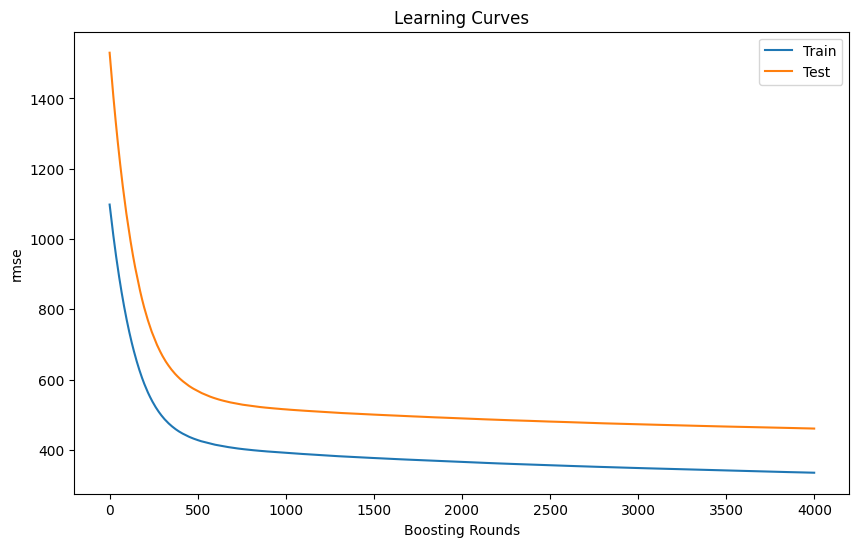

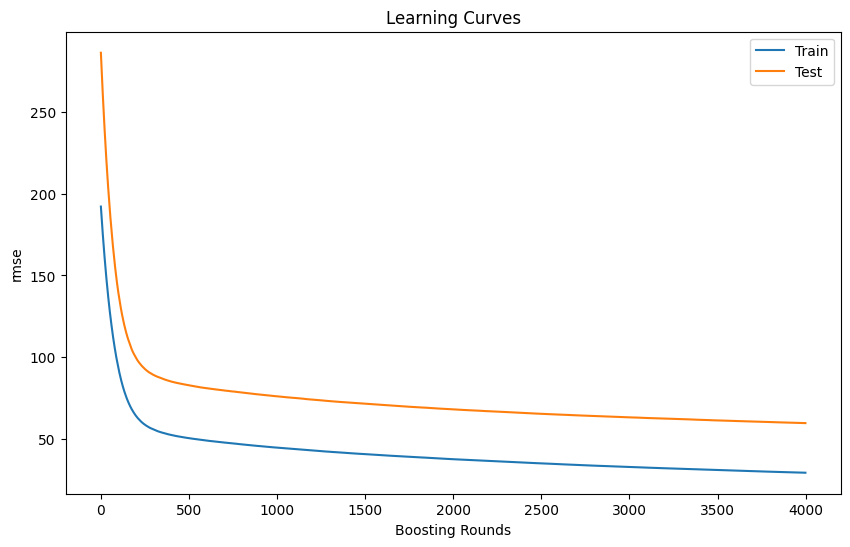

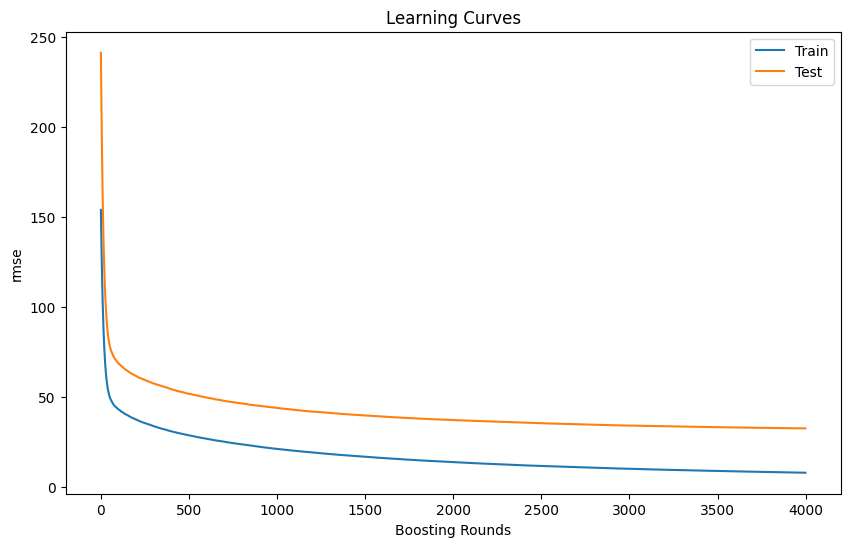

In [321]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0'][eval_metric]
test_errors = results['validation_1'][eval_metric]

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel(eval_metric)
plt.legend()
plt.title('Learning Curves')
plt.show()

In [322]:
min_error_a, min_error_b, min_error_c

(460.52864351722843, 59.58686787508395, 32.615803874534606)

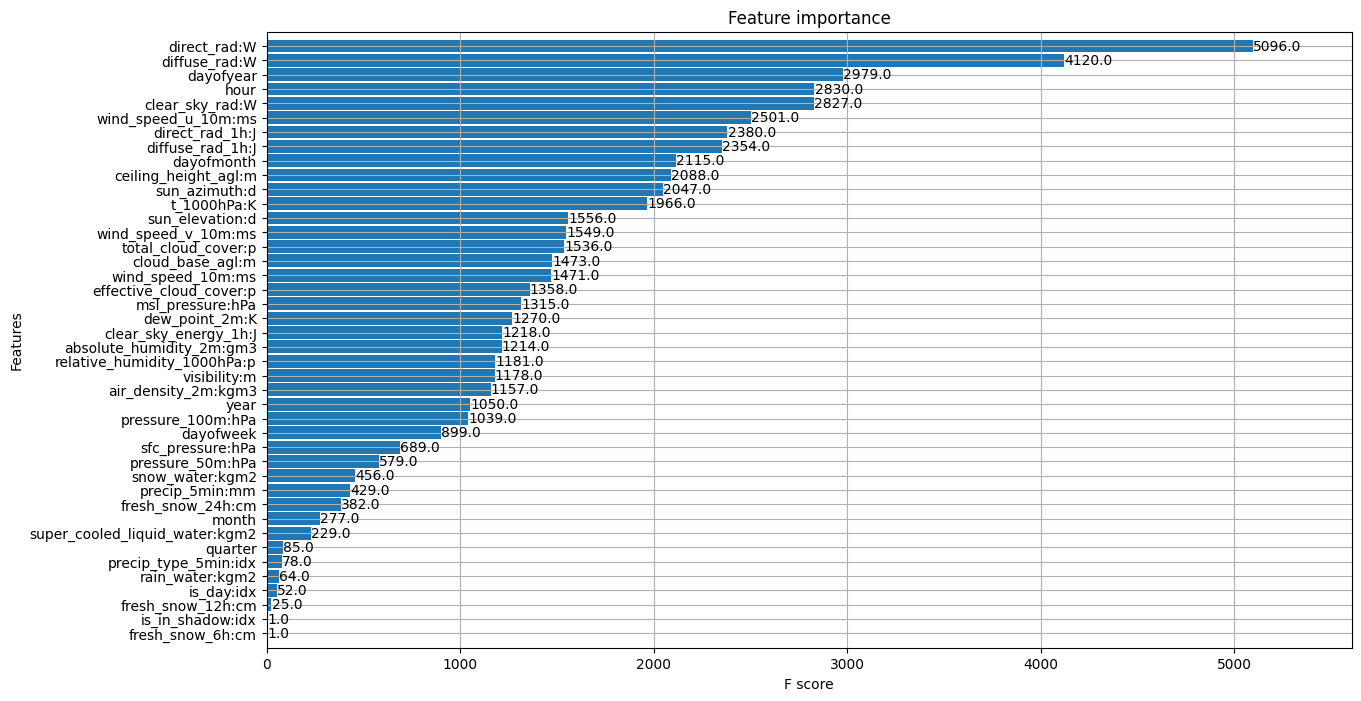

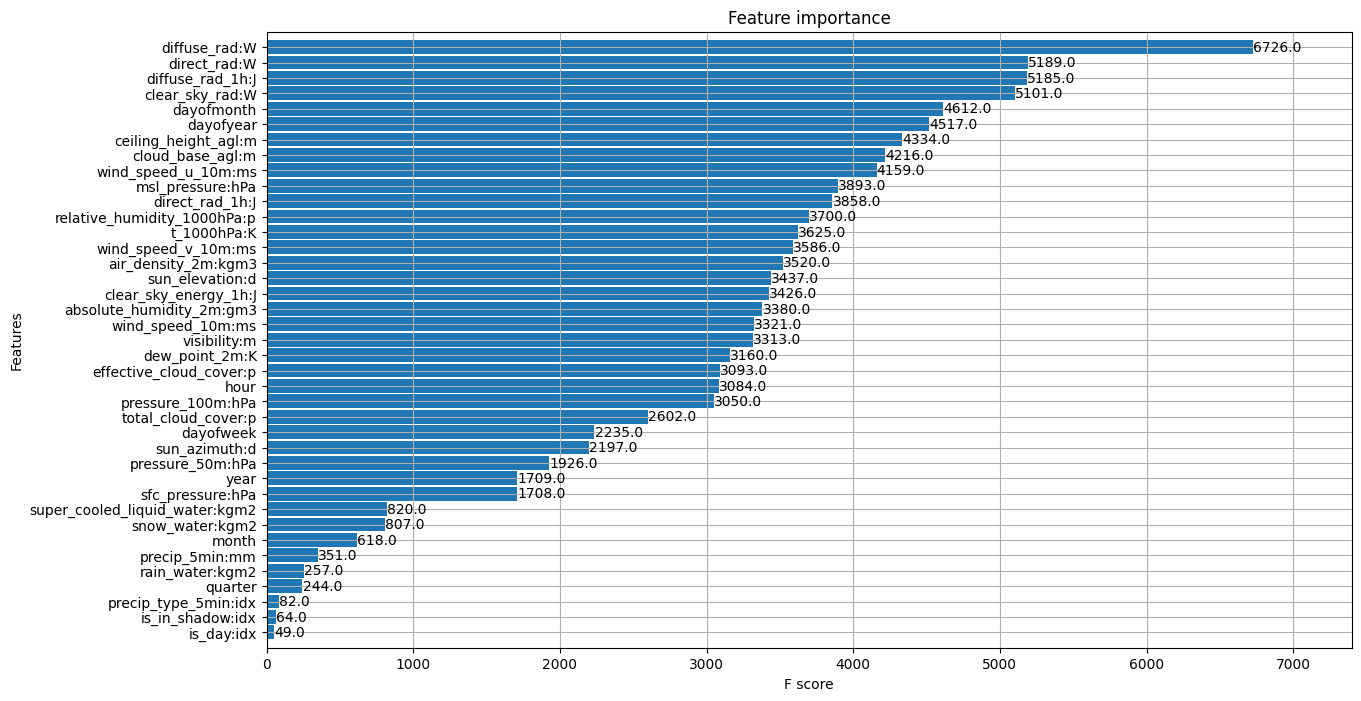

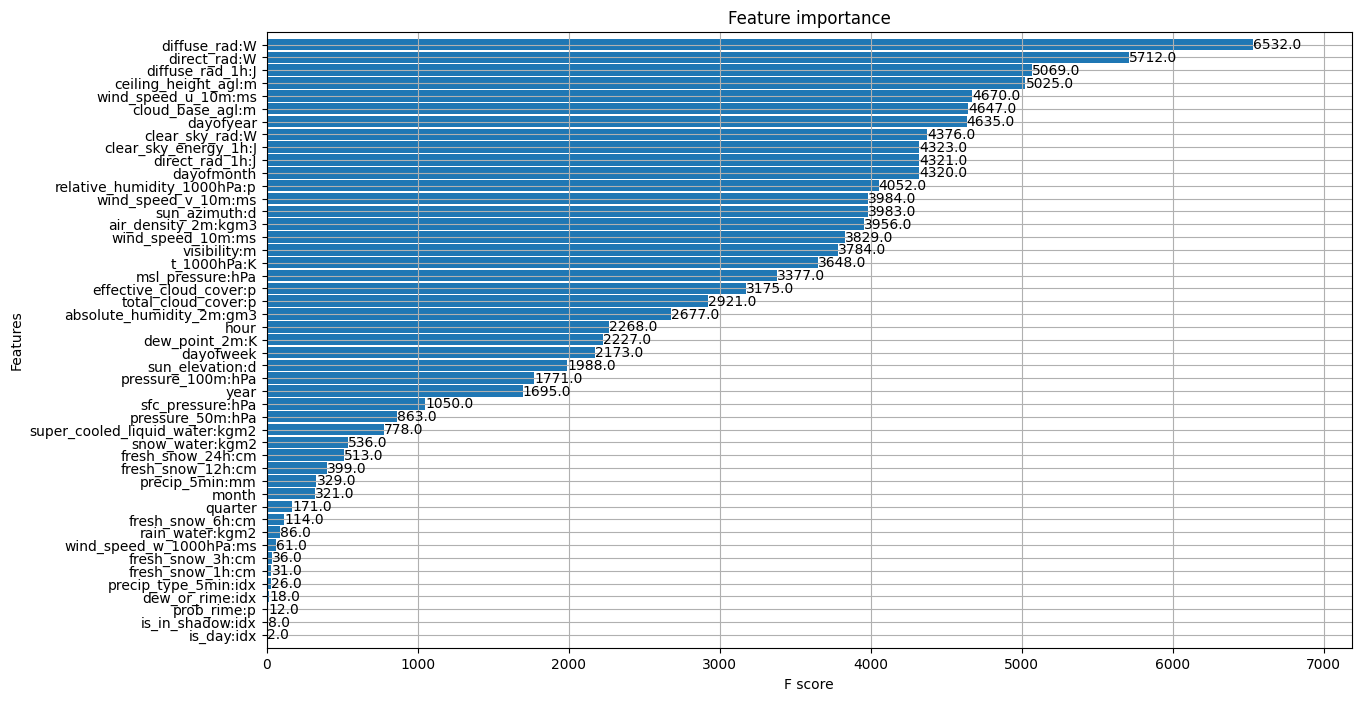

In [323]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8)

In [324]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [325]:
# XGBoost_separated_loc_4_inputs_n_estimators_10000_delta_0_min_StandardScaler_rmse_max_depth_3_mae_123_rmse_367_60_57_rd_subsets_42_by_day.csv



In [326]:
sum(pv_test_c['pv_measurement_prediction'] < 10 )


3228

In [327]:
pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_c[pv_test_c['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_1256/182118369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_1256/182118369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_1256/182118369.py:3: 

In [328]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_c['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

df_mae = pd.concat([pv_all_a, pv_all_b, pv_all_a])
mae = np.mean(np.abs(df_mae['pv_measurement'] - df_mae['pv_measurement_prediction']))
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 256.63357285973694 MAE b: 32.7058911849936 MAE c: 18.164664500291014
MAE on test set: 191.85453525610967


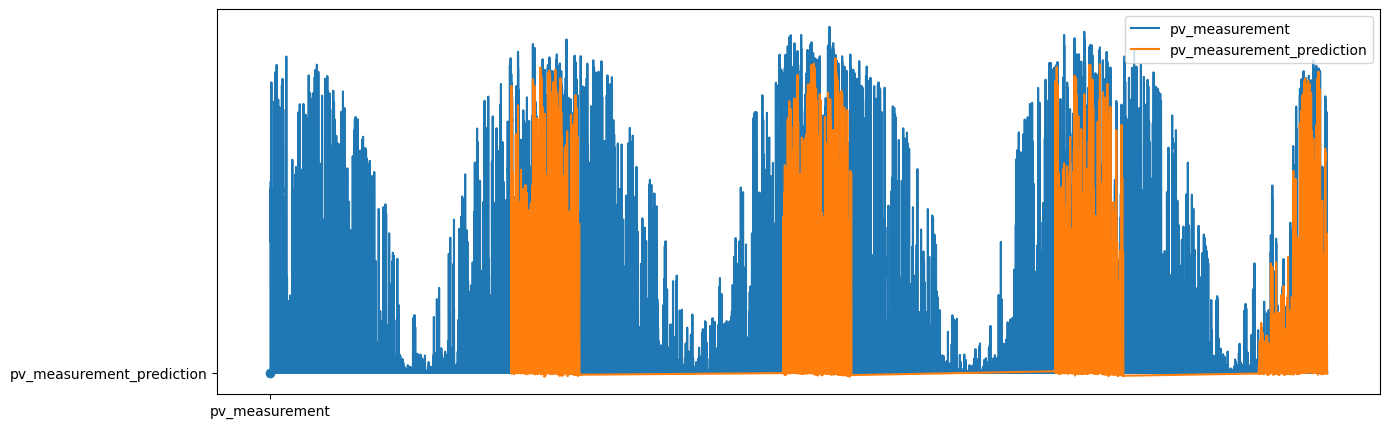

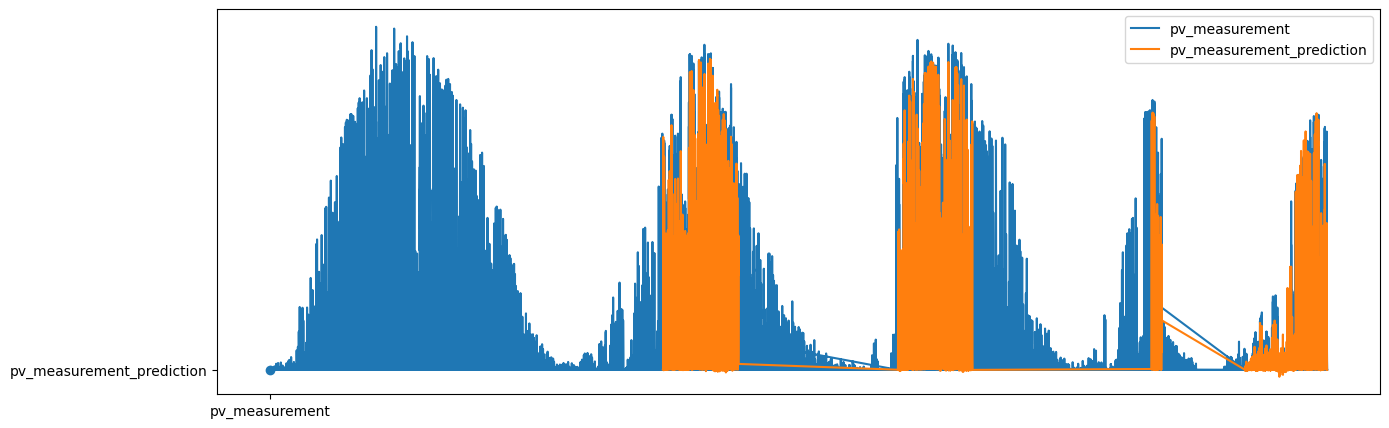

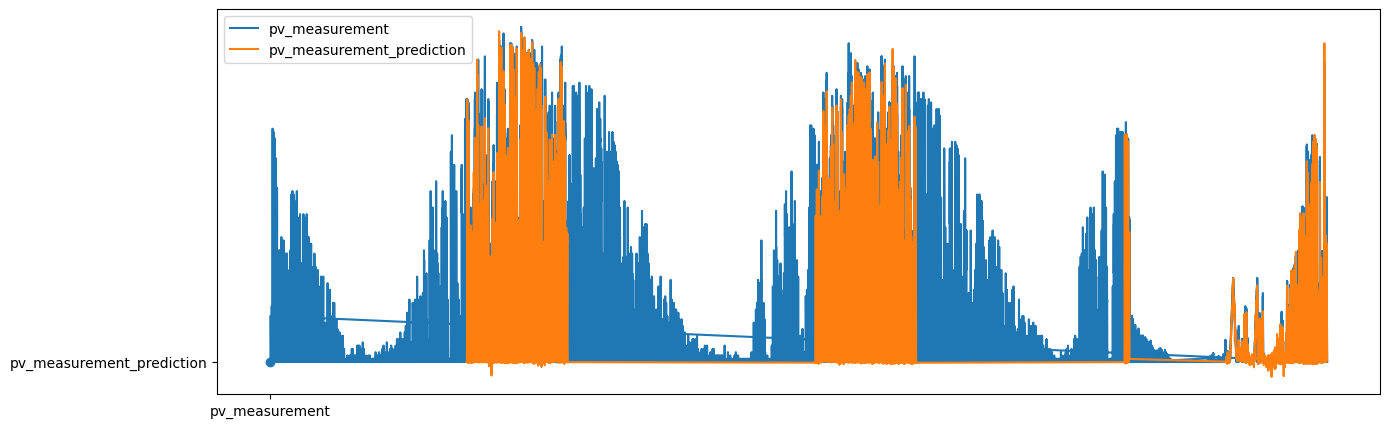

In [329]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5)).scatter('pv_measurement','pv_measurement_prediction')

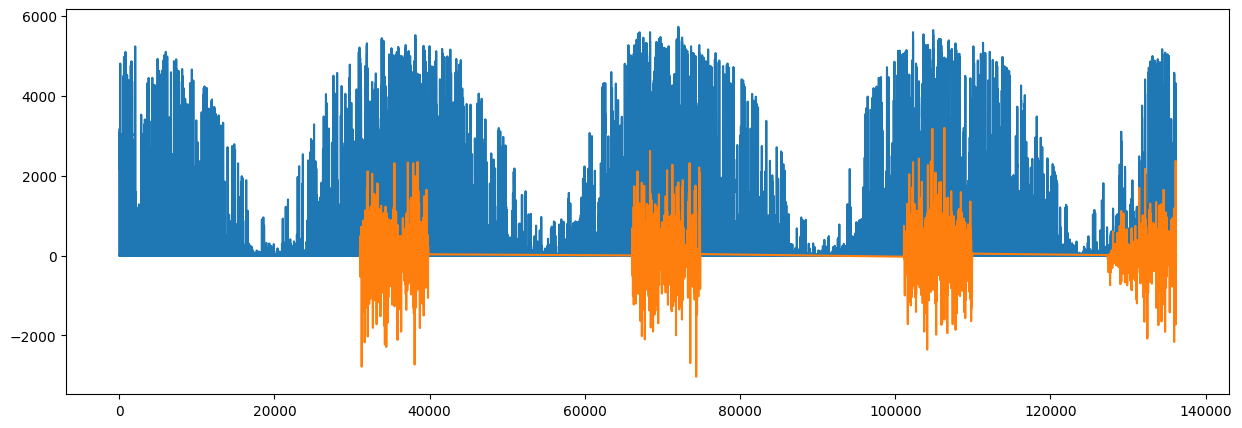

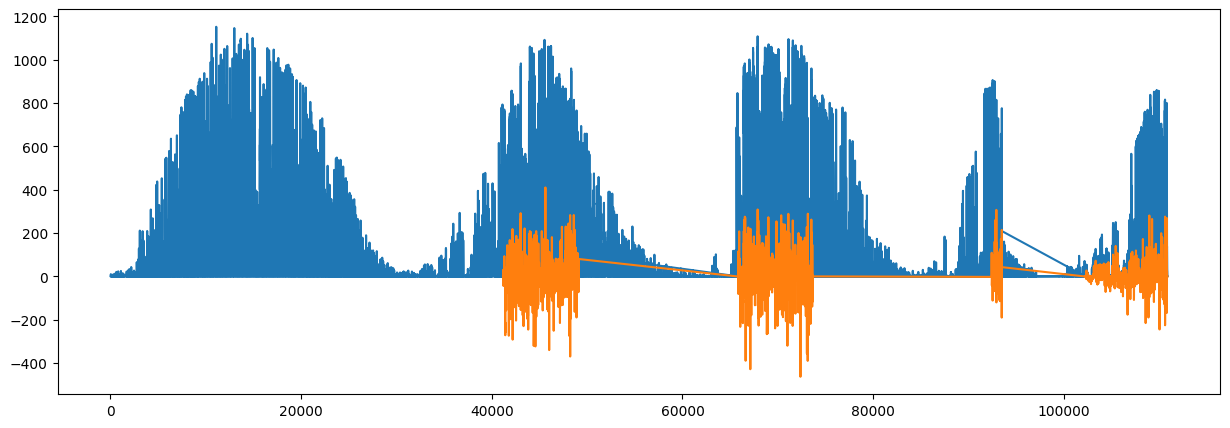

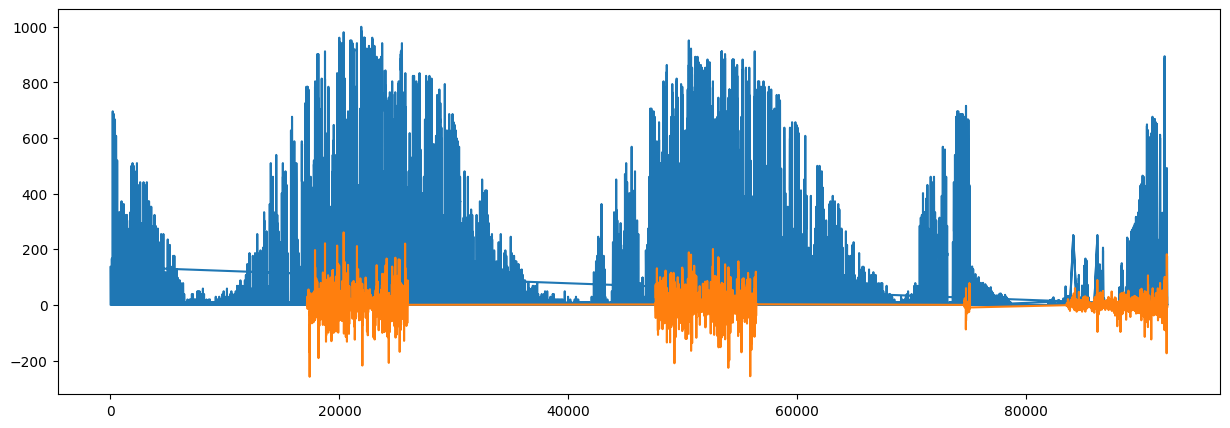

In [330]:
plt.figure(figsize=(15, 5))
plt.plot(pv_all_a['pv_measurement'])
plt.plot(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction'])
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(pv_all_b['pv_measurement'])
plt.plot(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction'])
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(pv_all_c['pv_measurement'])
plt.plot(pv_all_c['pv_measurement'] - pv_all_c['pv_measurement_prediction'])
plt.show()

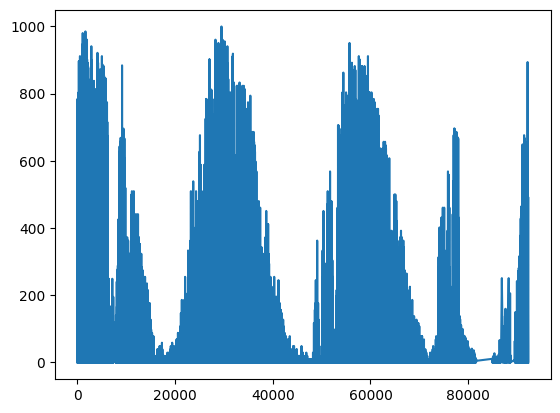

In [331]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [332]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [333]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [334]:
def preprocessing_test(df,scaler,loc):
  X_test = df.drop(["id", "location", "prediction"],axis=1)
  X_test = gestion_constant_columns(X_test, loc)

  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler, fit=False)
  return X_test

In [335]:
# merged_df_a['prob_rime:p', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'wind_speed_w_1000hPa:ms']

In [336]:
X_test_a_test = preprocessing_test(merged_df_a, scaler_a, 'A')
X_test_b_test = preprocessing_test(merged_df_b, scaler_b, 'B')
X_test_c_test = preprocessing_test(merged_df_c, scaler_c, 'C')

In [337]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

In [338]:
len(result_A) + len(result_B) + len(result_C)

2160

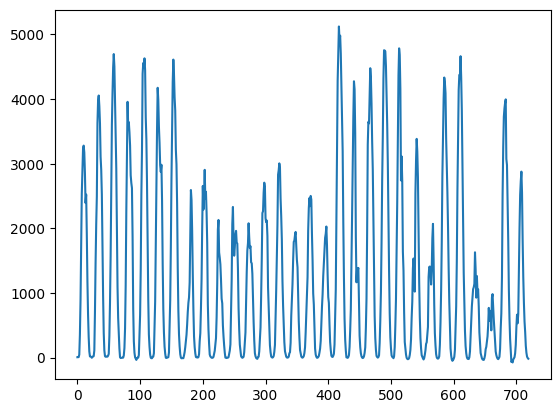

In [339]:
plt.plot(result_A)

In [340]:
# nom_fichier = 'XGBoost_Valentin_V2'
# repertoire = path
# result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
# test_copy['prediction'] = result
# sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
# sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [341]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [342]:
len(result_A), len(result_B), len(result_C)

(720, 720, 720)

In [343]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

3.8140116823165635

In [344]:
negative_mask = result < 5
result[negative_mask] = 0

In [345]:
nom_fichier = f'XGBoost_separated_loc_output_interpolate_{interpolation_method}_min_{scaler_name}_max_depth_{max_depth}_mae_{int(mae)}_{eval_metric}_{int(min_error_a)}_{int(min_error_b)}_{int(min_error_c)}_test_set_gen_{test_set_param}_{random_state}_by_day'
repertoire = submission_path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [346]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [347]:
negative_mask2 = result2 < 10
result2[negative_mask2] = 0